### Cab-Driver Agent

Cab drivers, like most people, are incentivised by a healthy growth in income. The goal of your project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.

Most drivers get a healthy number of ride requests from customers throughout the day. But with the recent hikes in electricity prices (all cabs are electric), many drivers complain that although their revenues are gradually increasing, their profits are almost flat. Thus, it is important that drivers choose the 'right' rides, i.e. choose the rides which are likely to maximise the total profit earned by the driver that day. 

In [3]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

### 1. Load the Time Matrix

In [4]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Check stats for the Time Matrix. This will help us in defining the 'next_step' function in the Environment.

In [5]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


In [6]:
# Track the state-action pair for convergence
States_track = collections.defaultdict(dict)
print(len(States_track))

0


In [7]:
sample_q_values = [
    ((1, 2, 4), (1, 2)),
    ((1, 8, 2), (1, 0))
]

In [8]:
# Initialise states to be tracked
def initialise_tracking_states():
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []
        
# let initialise the States_track dictornary
initialise_tracking_states()

In [9]:
# function to add q-value for sampled q-value state-action pair
def save_tracking_states(env, agent, state_size):
    for state in States_track.keys():
        for action in States_track[state].keys():
            q_values = agent.model.predict(np.array(env.state_encod_arch1(state)).reshape(1, state_size))
            q_value = np.take(q_values[0], env.action_space.index(action))
            States_track[state][action].append(q_value)

In [10]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### 2. Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [11]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = 0.005 #for 15k
        #self.epsilon_decay = -0.00015 #for 20k
        self.epsilon_min = 0.001
        
        self.batch_size = 256

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and actions (0,1) and (0,2).
        # self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        """
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) <= self.batch_size:
            return

        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        # initialise two matrices - update_input and update_output
        update_input = np.zeros((self.batch_size, self.state_size))
        update_output = np.zeros((self.batch_size, self.state_size))
        actions, rewards, done = [], [], []

        # populate update_input and update_output and the lists rewards, actions, done
        for i in range(self.batch_size):
            state, action, reward, next_state, done_boolean = mini_batch[i]
            update_input[i] = env.state_encod_arch1(state)     
            actions.append(action)
            rewards.append(reward)
            update_output[i] = env.state_encod_arch1(next_state)
            done.append(done_boolean)

        # predict the target q-values from states s
        target = self.model.predict(update_input)
        # target for q-network
        target_qval = self.model.predict(update_output)


        # update the target values
        for i in range(self.batch_size):
            if done[i]:
                target[i][actions[i]] = rewards[i]
            else: # non-terminal state
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
        # model fit
        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save(self):
        self.model.save_weights('model_weights.h5')



### 3. DQN block

We train the Agent here.

Till we reach the Terminal state we do the following:
-   We pick the Epsilon-Greedy action
-   Agent selecting trip/action on current state
-   Evaluate your reward and next state
-   append the experience to the memory
-   train the model and also get the loss
-   Keep track of rewards  
        

In [12]:
episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 4000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

### 4. Run the episodes, build up replay buffer and train the model.
### Note:
#### The moment total episode time exceeds 720 (30 days), we ignore the most recent ride and do NOT save that experience in the replay memory
#### The init state is randomly picked from the state space for each episode

In [13]:
!pip install tqdm

You should consider upgrading via the 'd:\repositories\upgrad-pgd-ml---ai\tensorflow_env\scripts\python.exe -m pip install --upgrade pip' command.


In [14]:
from tqdm import trange


start_time = time.time()
score_tracked = []

track_reward = False

for episode in trange(n_episodes, desc= 'Episodes'):

    done = False
    score = 0
    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init


    total_time = 0  # Total time driver rode in this episode
    counter = 0
    while not done:
        counter += 1
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete within 24 * 30 hours, termninate it and continue
            # with another episode
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            if (counter%10 == 0):
                agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    agent.epsilon = (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay * episode)

    # every 500 episodes:
    if ((episode + 1) % 500 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        # keeping track of q-value for state-action pair defined in sample_q_values
        save_tracking_states(env, agent, state_size)

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save()

save_obj(States_track,'States_track')
elapsed_time = time.time() - start_time
print("Training completed. Time taken:[{}]".format(elapsed_time))

Episodes:   0%|          | 0/4000 [00:00<?, ?it/s]

Saving Model 0


Episodes:  12%|█▎        | 500/4000 [30:57<4:22:44,  4.50s/it]

episode 499, reward 1275.0, memory_length 2000, epsilon 0.08241395494035324 total_time 725.0


Episodes:  25%|██▌       | 1000/4000 [1:08:45<3:47:08,  4.54s/it]

episode 999, reward 1067.0, memory_length 2000, epsilon 0.006764949377868953 total_time 728.0


Episodes:  25%|██▌       | 1001/4000 [1:08:49<3:35:24,  4.31s/it]

Saving Model 1000


Episodes:  38%|███▊      | 1500/4000 [1:46:33<3:12:01,  4.61s/it]

episode 1499, reward 1233.0, memory_length 2000, epsilon 0.000555300860373118 total_time 726.0


Episodes:  50%|█████     | 2000/4000 [2:28:44<2:58:35,  5.36s/it]

episode 1999, reward 1448.0, memory_length 2000, epsilon 4.5581870359577164e-05 total_time 722.0


Episodes:  50%|█████     | 2001/4000 [2:28:49<2:52:34,  5.18s/it]

Saving Model 2000


Episodes:  62%|██████▎   | 2500/4000 [3:13:50<2:24:44,  5.79s/it]

episode 2499, reward 1512.0, memory_length 2000, epsilon 3.741587765740625e-06 total_time 722.0


Episodes:  75%|███████▌  | 3000/4000 [4:03:07<1:35:20,  5.72s/it]

episode 2999, reward 1445.0, memory_length 2000, epsilon 3.071282266020158e-07 total_time 724.0


Episodes:  75%|███████▌  | 3001/4000 [4:03:14<1:36:51,  5.82s/it]

Saving Model 3000


Episodes:  88%|████████▊ | 3500/4000 [4:48:44<43:36,  5.23s/it]

episode 3499, reward 1180.0, memory_length 2000, epsilon 2.5210620057986944e-08 total_time 729.0


Episodes: 100%|██████████| 4000/4000 [5:35:38<00:00,  5.03s/it]

episode 3999, reward 693.0, memory_length 2000, epsilon 2.0694137127674936e-09 total_time 721.0


Training completed. Time taken:[20140.52679491043]


### Tracking Convergence
### Check the states tracked for Q-values convergence

- Let check the convergence of state tracked q-value during training

In [16]:
with open('States_track.pkl', 'rb') as handle:
    States_track = pickle.load(handle)

In [17]:
for key, value in States_track.items():
    for k,v in value.items():
        print('[', key, k, ']:', len(v))

[ (1, 2, 4) (1, 2) ]: 800
[ (1, 8, 2) (1, 0) ]: 800


### 5. Plot the Q-Value convergence for state action pairs

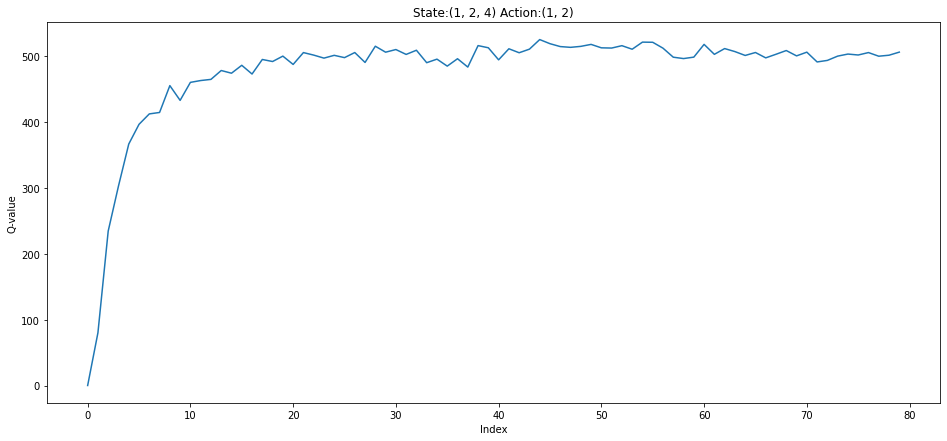

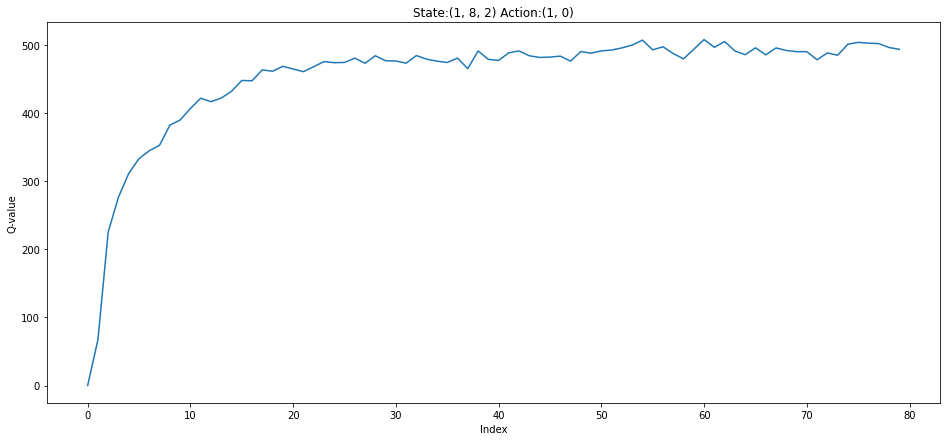

In [19]:
# Lets plot the convergence of Q-value state-action pair

plt.figure(0, figsize=(16,7))

# plot 1
plt.title('State:' + str(sample_q_values[0][0]) + ' ' +  'Action:' + str(sample_q_values[0][1]))
plt.xlabel('Index')
plt.ylabel('Q-value')
plt.plot(
    np.asarray(range(0, len(States_track[sample_q_values[0][0]].get(sample_q_values[0][1])[::10]))),
    np.asarray(States_track[sample_q_values[0][0]].get(sample_q_values[0][1])[::10]))
plt.show()


# plot 2
plt.figure(0, figsize=(16,7))
plt.title('State:' + str(sample_q_values[1][0]) + ' ' +  'Action:' + str(sample_q_values[1][1]))
plt.xlabel('Index')
plt.ylabel('Q-value')
plt.plot(
    np.asarray(range(0, len(States_track[sample_q_values[1][0]].get(sample_q_values[1][1])[::10]))),
    np.asarray(States_track[sample_q_values[1][0]].get(sample_q_values[1][1])[::10]))
plt.show()

### Both the plots clearly indicate that it has converged and q-value is within a small margin. 

### 6. Track rewards per episode.

In [20]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

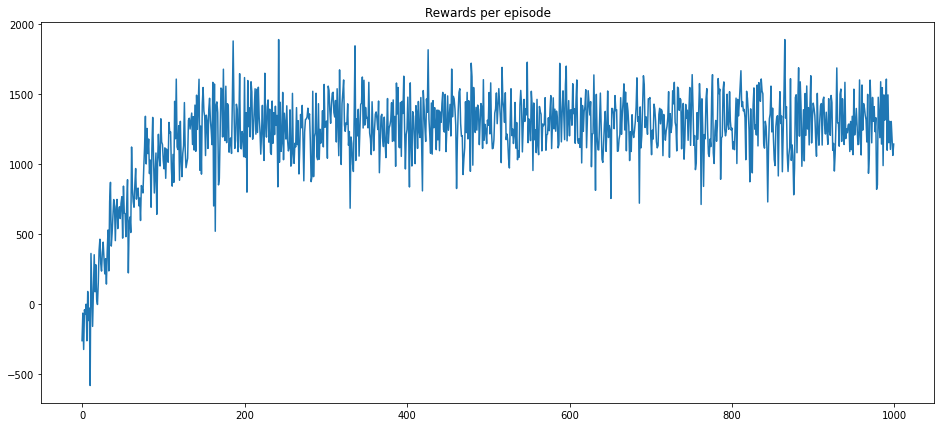

In [21]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

As seen from the plot above, the agent can achieve rewards in the range of 1300 - 1500.

As the initialization is more or less random, some states may be less rewarding than others

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [22]:
import numpy as np
time = np.arange(0,15000)
epsilon = []
for i in range(0,15000):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

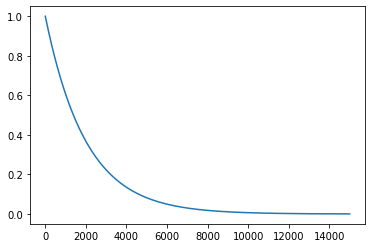

In [23]:
import matplotlib.pyplot as plt
plt.plot(time, epsilon)
plt.show()